In [1]:
import csv
import pandas as pd
ori_file_path = './benchmark_results.csv'
ori_models_list = ["784_56_10", "196_25_10", "196_24_14_10", "28_6_16_10_5", "14_5_11_80_10_3", "28_6_16_120_84_10_5"]
colors = {'circomlib-ml': 'C0',
          'ezkl (accuracy)': 'C1',
          'ezkl (resource)': 'C2',
          'opml': 'C3',
          'zkml': 'C4'}

In [2]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(ori_file_path)

# Check if the DataFrame needs filtering to exclude rows with "Combined" in the "Notes" column
df = df[~df['Notes'].str.contains('Combined', na=False)]

# Calculate the total proving time cost for each row
df['Total Proving Time (s)'] = df['Testing Size'] * df['Avg Proving Time (s)']

# Sum the 'Total Proving Time (s)' column
total_proving_time_seconds = df['Total Proving Time (s)'].sum()

# Convert the total proving time from seconds to minutes and hours
total_proving_time_minutes = total_proving_time_seconds / 60
total_proving_time_hours = total_proving_time_minutes / 60

# Output the total proving time in minutes and hours
print(f"Total Proving Time: {total_proving_time_seconds:.2f} seconds")
print(f"Total Proving Time: {total_proving_time_minutes:.2f} minutes")
print(f"Total Proving Time: {total_proving_time_hours:.2f} hours")



Total Proving Time: 759601.95 seconds
Total Proving Time: 12660.03 minutes
Total Proving Time: 211.00 hours


## Prepare

In [3]:
def read_data_for_architectures(file_path, target_architectures, skip = None):
    # Ensure target_architectures is a list for uniform processing
    if isinstance(target_architectures, str):
        target_architectures = [target_architectures]

    results = {arch: {} for arch in target_architectures}

    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        
        for row in reader:

            framework = row['Framework'].split(' ')[0]
            if skip != None and skip in framework:
                continue
            #print (framework)
            #frameworks.append(framework)
            architecture = row['Architecture']
            notes = row['Notes']
            #print (notes)

            if 'accuracy' in notes:
                framework += f' (accuracy)'
            elif 'resource' in notes:
                framework += f' (resource)'
            
            for target_arch in target_architectures:
                if architecture.lower() == target_arch.lower():
                    # This line ensures the last matching entry for each framework is kept
                    results[target_arch][framework] = [
                        row['Accuracy Loss (%)'],
                        row['Avg Memory Usage (MB)'],
                        row['Std Memory Usage'],
                        row['Avg Proving Time (s)'],
                        row['Std Proving Time']
                    ]
    
    return results


In [4]:
def target_arch(model_name):
    layers = model_name.split("_")
    if int(layers[0]) < 30:
        arch = "Input-Conv2d-Conv2d" + (len(layers)-4) * "-Dense" + "_Kernal"
        layers[0] = str(int(layers[0])**2)
        target = f'{arch} ({"x".join(layers[:-1])}_{layers[-1]}x{layers[-1]})'
    else:
        layers = model_name.split("_")
        arch = "Input" + (len(layers)-1) * "-Dense"
        target = f'{arch} ({"x".join(layers)})'
    
    return target

### Combine benchmark results

In [5]:
def read_and_combine_data(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    #print ('Header:', df.head())

    # Group data by Framework and Architecture for processing
    grouped = df.groupby(['Framework', 'Architecture'])
    #print (grouped)
    
    for (framework, architecture), group in grouped:
        if len(group) == 2:  # Expecting two entries per group for combination
            base = group.iloc[0]
            follow_up = group.iloc[1]
            
            # Ensure we start with the base and follow up in the correct order
            if "start from 1000" in str(follow_up['Notes']):
                base, follow_up = follow_up, base  # Swap if in wrong order
            
            combined = base.copy()
            n1, n2 = 1000, 1500
            combined['Testing Size'] = 2500
            
            # Combine the metrics
            for metric in ['Accuracy Loss (%)', 'Avg Memory Usage (MB)', 'Avg Proving Time (s)']:
                combined[metric] = (n1 * base[metric] + n2 * follow_up[metric]) / (n1 + n2)
                
            for metric in ['Std Memory Usage', 'Std Proving Time']:
                # Placeholder for standard deviation combination, here we simply copy from follow_up
                # In reality, you should calculate combined standard deviation using a proper statistical method
                combined[metric] = follow_up[metric]
                

            combined['Notes'] = "Combined 0-2500"
            combined = combined.to_dict()
            for key in combined:
                combined[key] = [combined[key]]

            new_row_df = pd.DataFrame(combined)
            df = pd.concat([df, new_row_df], ignore_index=True)

    df.to_csv(file_path, index=False)

## Analysis

In [6]:
def extract(data, architectures):
    frameworks = {arch: list(data[arch].keys()) for arch in architectures}
    #ist(data[architectures[0]].keys())

    memory_usage = {arch: [] for arch in architectures}
    accuracy_loss = {arch: [] for arch in architectures}
    proving_time = {arch: [] for arch in architectures}

    # Iterate over the original data to populate the new structures
    for arch, fw_data in data.items():
        for fw in frameworks[arch]:
            # Append memory usage and proving time to the respective dictionaries
            # Convert string values to float for numerical processing
            accuracy_loss[arch].append(float(fw_data[fw][0]))
            memory_usage[arch].append(float(fw_data[fw][1]))
            proving_time[arch].append(float(fw_data[fw][3]))

            if not fw_data[fw]:
                print ('Missing here at:', fw, arch)

    return frameworks, accuracy_loss, memory_usage, proving_time

def normalize(data):
    """Normalize the data so that lower values result in higher normalized scores.
    A lower original value results in a normalized value closer to 1."""
    min_val = min(data)
    max_val = max(data)
    # Invert the normalization: The best (lowest) value gets a score of 1, and the worst (highest) value gets a score of 0.
    return [(max_val - x) / (max_val - min_val) if max_val - min_val else 1 for x in data]


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def wrap_text(text, width=20):
    """Wrap text to the specified width."""
    if len(text) > width:
        return '\n'.join(text.split(' '))
    return text


def plot_bar(archs, frameworks_dict, accuracy_loss, memory_usage, proving_time, trans):
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))  # Three subplots for each metric
    
    # Helper function to plot each metric
    def plot_metric(ax, metric_values, title, ylabel):
        all_frameworks = sorted(set(sum(frameworks_dict.values(), [])))  # Flatten and sort all framework names
        min_val, max_val = float('inf'), -float('inf')  # Initialize min and max values

        for i, arch in enumerate(archs):
            indices = np.arange(len(all_frameworks))
            data = []
            zero_values_indices = []  # To keep track of indices with values

            for fw in all_frameworks:
                if fw in frameworks_dict.get(arch, []):
                    index = frameworks_dict[arch].index(fw)
                    value = metric_values.get(arch, [0] * len(frameworks_dict[arch]))[index]
                    #values_indices.append(value)
                    if value == 0:
                        zero_values_indices.append(indices[len(data)])
                    #     #print ('too small!')
                    #     #value = -0.02
                    data.append(value)
                    # # Update min and max values considering the actual data points
                    # if value != 'placeholder' and value > -1:  # Ignore placeholders and missing data
                    min_val = min(min_val, value)
                    max_val = max(max_val, value)
                else:
                    #na_values_indices.append(indices[len(data)])
                    data.append(-500)  # Indicate missing data

            bars = ax.bar(indices + i*0.2, data, width=0.2, label=wrap_text(arch))
            #print ('0', zero_values_indices)
            #print ('NA', na_values_indices)

            # Mark zero and missing data.
            for j, bar in enumerate(bars):
                if data[j] == -500:
                    bar.set_hatch('//')
                    bar.set_facecolor('none')
                    bar.set_edgecolor('black')
                elif data[j] == 0:
                    ax.text(bar.get_x() + bar.get_width() / 2, 0, '0',
                            ha='center', va='bottom', color='black', fontsize=9)

        ax.set_xticks(indices)
        ax.set_xticklabels(all_frameworks, rotation=45, ha="right")
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        
        # print ('data:',data)
        # print ('min',min_val, 'max', max_val)
        # Adjust y-axis limits.
        ax.set_ylim([min_val - (max_val - min_val) * 0.05, max_val + (max_val - min_val) * 0.1])

        # # Draw a horizontal line at y=0
        # ax.axhline(y=0, color='black', linewidth=1.5, linestyle='--')

        # Add a legend for missing data.
        ax.bar(0, 0, color='gray', hatch='//', label='Missing Data')
        ax.legend(title="Architecture", loc='upper left')

    # Plot each metric
    plot_metric(ax[0], accuracy_loss, 'Accuracy Loss (%)', 'Accuracy Loss (%)')
    plot_metric(ax[1], memory_usage, 'Average Memory Usage (MB)', 'Memory Usage (MB)')
    plot_metric(ax[2], proving_time, 'Average Proving Time (s)', 'Proving Time (s)')
    
    plt.tight_layout()
    plt.savefig(f'./bar_chart/{trans}')
    plt.show()


In [8]:
def prepare_radar_data(archs, frameworks_dict, accuracy_loss, memory_usage, proving_time):
    # Normalize the data
    normalized_memory_usage = {arch: normalize(values) for arch, values in memory_usage.items()}
    normalized_proving_time = {arch: normalize(values) for arch, values in proving_time.items()}
    normalized_accuracy_loss = {arch: normalize(values) for arch, values in accuracy_loss.items()}
    
    # Prepare the transition data and calculate sums
    transition_data = {}
    sums_per_arch = {arch: {} for arch in archs}  # Stores the sum of scores for each framework per architecture
    
    # Find the intersection of frameworks present in both dictionary keys
    # frameworks = list(set(frameworks_dict[archs[0]]) & set(frameworks_dict[archs[1]]))

    all_frameworks = set(sum(frameworks_dict.values(), []))
    for fw in all_frameworks:
        transition_data[fw] = []
                
    for arch in archs:
        frameworks = frameworks_dict[arch]
        for fw in all_frameworks:

            if fw not in frameworks:
                transition_data[fw].append((-1,-1,-1))
                continue
            
            # Extract the normalized scores for the current framework and architecture
            accu_score = normalized_accuracy_loss[arch][frameworks.index(fw)]
            mem_score = normalized_memory_usage[arch][frameworks.index(fw)]
            time_score = normalized_proving_time[arch][frameworks.index(fw)]
            
            # Append the 3-dimensional vector
            transition_data[fw].append((accu_score, mem_score, time_score))
            
            # Calculate the sum of normalized scores
            sum_scores = accu_score + mem_score + time_score
            sums_per_arch[arch][fw] = sum_scores
            
    # Rank frameworks for each architecture based on the sum of scores
    ranks_per_arch = {}
    for arch in archs:
        # Sort frameworks based on sum of scores, higher is better
        ranked_frameworks = sorted(sums_per_arch[arch].items(), key=lambda x: x[1], reverse=True)
        ranks_per_arch[arch] = ranked_frameworks

    # # Output the transition vectors and sum of scores for each framework, and their ranks
    # for fw, vectors in transition_data.items():
    #     # if vectors == (-1,-1,-1):
    #     #     continue
    #     print(f"{fw} transitions:")
    #     for i, arch in enumerate(archs):
    #         if vectors[i] != (-1,-1,-1):
    #         #if sums_per_arch[arch][fw]:
    #             print(f"  {arch}: {vectors[i]}, Sum of scores: {sums_per_arch[arch][fw]}")
    #     print()

    # Output ranks for each architecture
    for arch, ranks in ranks_per_arch.items():
        print(f"Ranking for {arch}:")
        for rank, (fw, score) in enumerate(ranks, start=1):
            print(f"  {rank}. {fw} with a score of {score}")
        print()

    return transition_data


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
def plot_radar_trans(archs, transition_data, trans):
    # Metrics
    metrics = ['Accuracy Loss', 'Memory Usage', 'Proving Time']

    # Prepare the plot
    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Filter out entries where any tuple contains (-1, -1, -1)
    updated_transition_data = {
        key: vectors for key, vectors in transition_data.items()
        if not any(vector == (-1, -1, -1) for vector in vectors)
    }

    num = len(updated_transition_data.keys())
    if num == 4:
        nrows = 2
        ncols = 2
        figsize = (10,10)
    else:
        ncols = 3
        nrows = int(num/ncols + 0.7)
        figsize = (20, 5 * nrows)

    # Create a figure
    fig, axs = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True))
    axs = axs.flatten()  # Flatten to easily iterate over



    for ax, (fw, vectors) in zip(axs, updated_transition_data.items()):
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        
        # Draw one axe per variable + add labels if needed
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        
        # Plot each transition for the framework, without adding a legend here
        for i, vector in enumerate(vectors):
            data = np.array(vector + vector[:1])  # Repeat the first value at the end to close the loop
            ax.plot(angles, data, 'o-', linewidth=2)
            ax.fill(angles, data, alpha=0.25)
        
        ax.set_title(fw)

    # Create custom legend entries
    legend_elements = [mlines.Line2D([], [], color='blue', marker='o', linestyle='-', linewidth=2, label=archs[0]),
                    mlines.Line2D([], [], color='orange', marker='o', linestyle='-', linewidth=2, label=archs[1])]

    # Place a single legend outside the subplots
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.savefig(f'./radar_chart/factors/{trans}', bbox_inches = 'tight')
    plt.show()


In [10]:
def plot_radar_arch(transition_data, arch, archs, colors):
    index = archs.index(arch)
    # Metrics
    metrics = ['Accuracy Loss', 'Memory Usage', 'Proving Time']

    # Number of variables we're plotting
    num_vars = len(metrics)

    # Split the circle into even parts and save angles so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The radar chart plot needs to be a closed circle, so we need to append the start value to the end.
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

    # Draw y-labels (optionally adjust the range based on your scores)
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)

    for fw, vectors in transition_data.items():
        values = vectors[index]
        if values == (-1,-1,-1):
            continue
        # Radar chart plot needs to be a closed loop, so we need to append the start value to the end.
        values += values[:1]

        
        ax.plot(angles, values, label=fw, color=colors[fw])
        ax.fill(angles, values, alpha=0.1)

    plt.title(f'Framework Performance Comparison\nArchitecture: {arch}')
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.1))
    model_name = arch.split(' ')[1][1:-1]
    plt.savefig(f'./radar_chart/archs/{model_name}')
    plt.show()



### DNN Models

In [12]:
architectures = [target_arch(ori_models_list[2]), target_arch(ori_models_list[1]), target_arch(ori_models_list[0])]
data = read_data_for_architectures('./benchmark_results.csv', architectures, skip='opml')
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

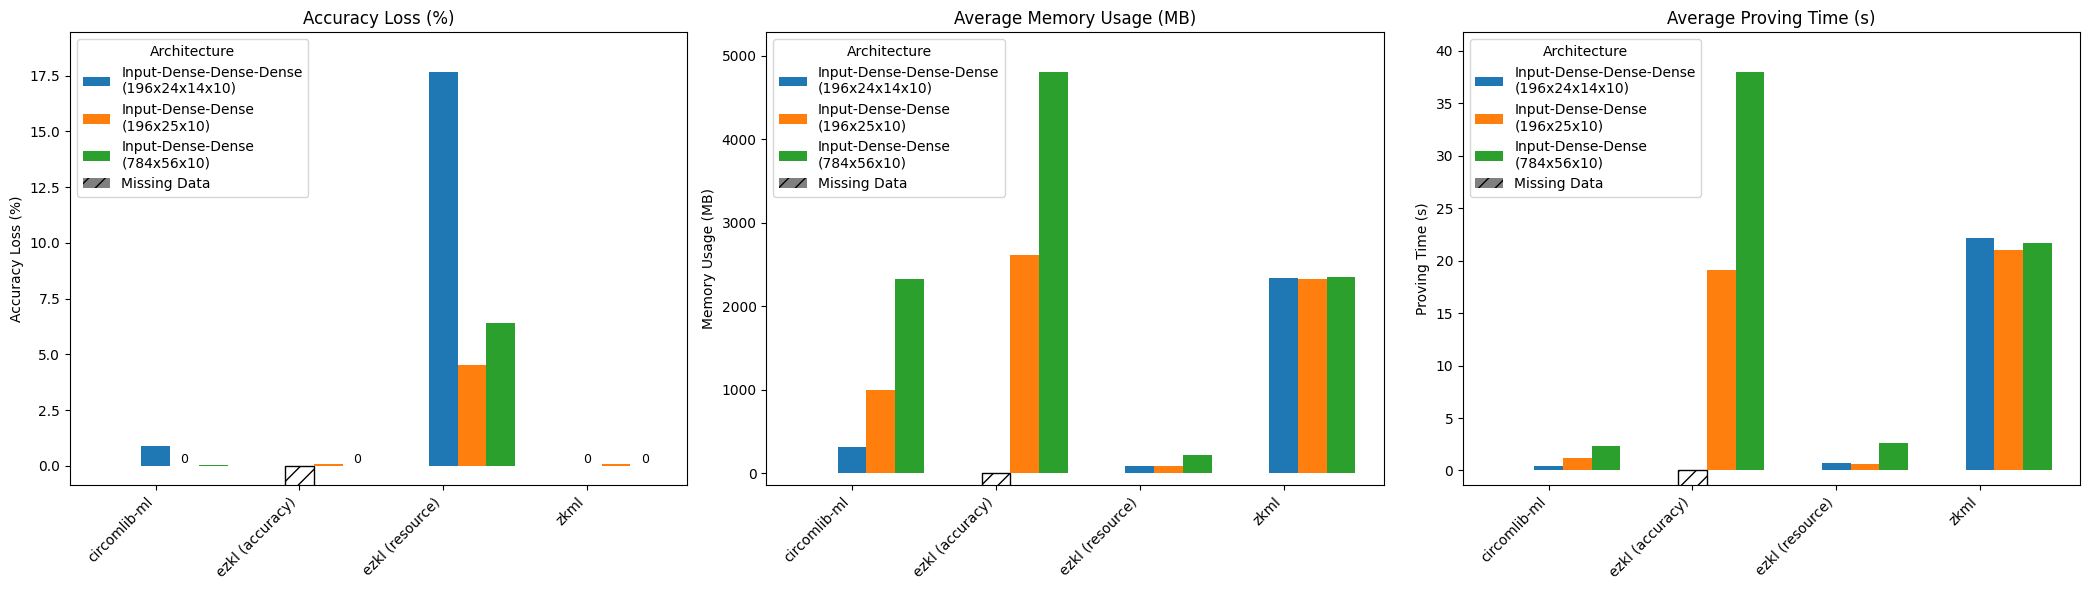

In [13]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time, "dnn_comparisons")

### CNN Models

In [14]:
ori_models_list

['784_56_10',
 '196_25_10',
 '196_24_14_10',
 '28_6_16_10_5',
 '14_5_11_80_10_3',
 '28_6_16_120_84_10_5']

In [15]:
architectures = [target_arch(ori_models_list[3]), target_arch(ori_models_list[4]), target_arch(ori_models_list[5])]
data = read_data_for_architectures('./benchmark_results.csv', architectures, skip='opml')
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

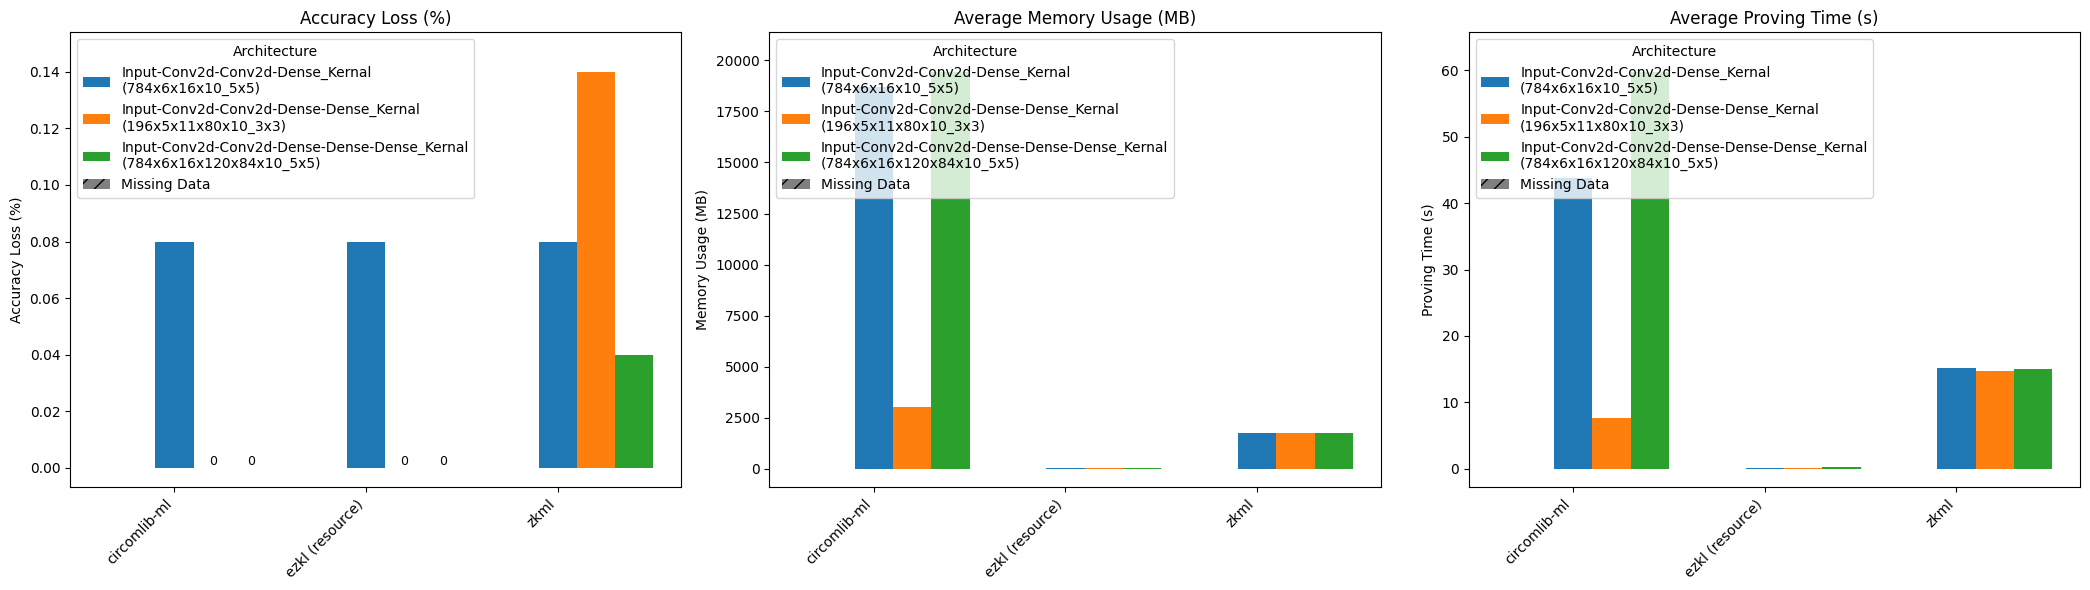

In [16]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time, "cnn_comparisons")

### Varing Num of Layer in DNN

In [19]:
trans = 'num_layer-varying_dnn'

In [20]:
architectures = [target_arch(ori_models_list[1]), target_arch(ori_models_list[2])]
data = read_data_for_architectures('./benchmark_results.csv', architectures, skip="opml")
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)


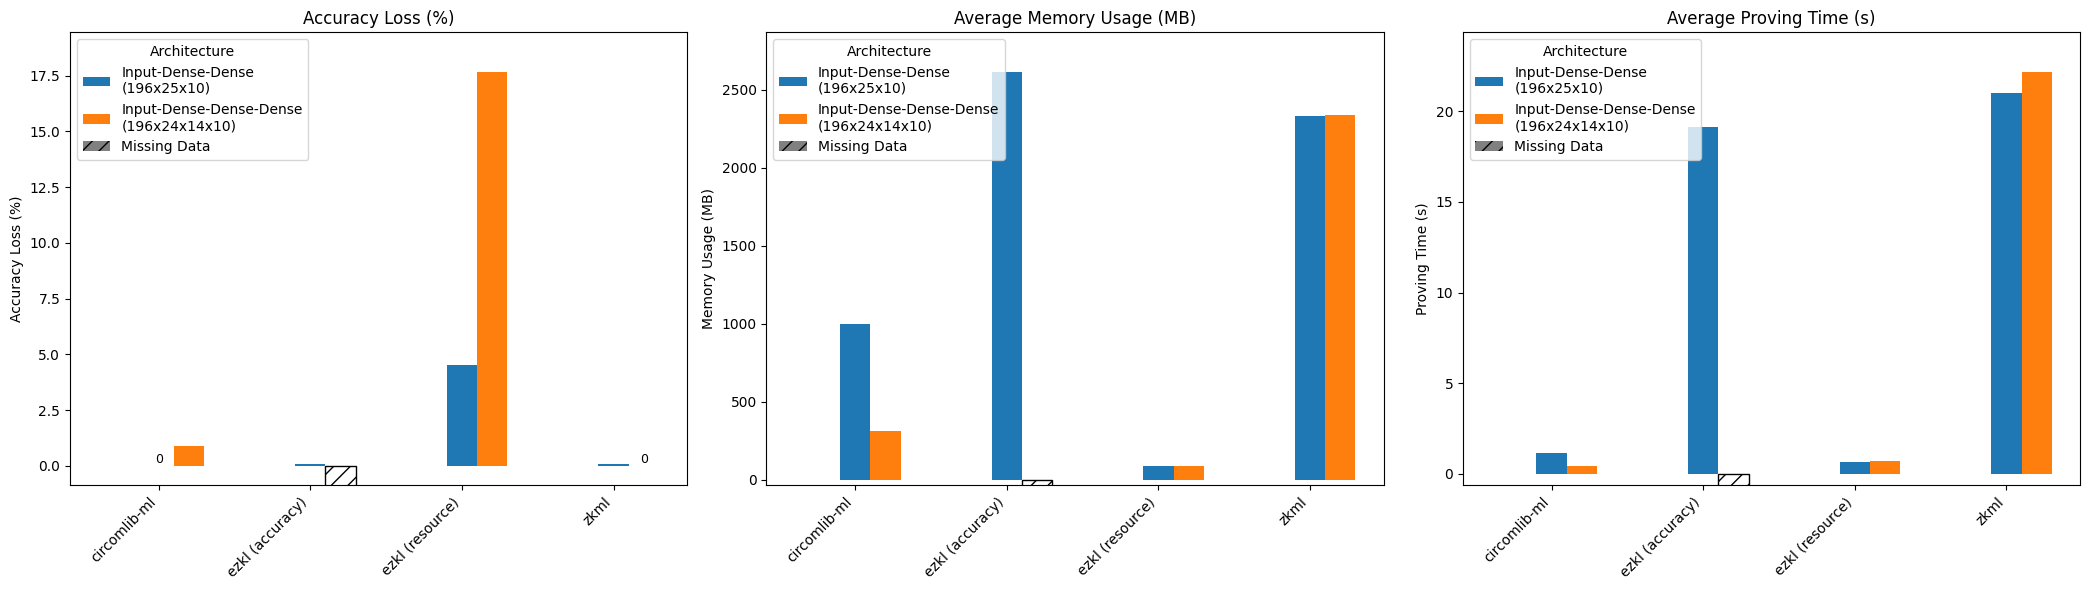

In [21]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time,trans)

In [22]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Dense-Dense (196x25x10):
  1. circomlib-ml with a score of 2.615287455004253
  2. ezkl (resource) with a score of 2.0
  3. zkml with a score of 1.0952031831552562
  4. ezkl (accuracy) with a score of 1.0732440705583803

Ranking for Input-Dense-Dense-Dense (196x24x14x10):
  1. circomlib-ml with a score of 2.8503668997135163
  2. ezkl (resource) with a score of 1.9892746198635494
  3. zkml with a score of 1.0



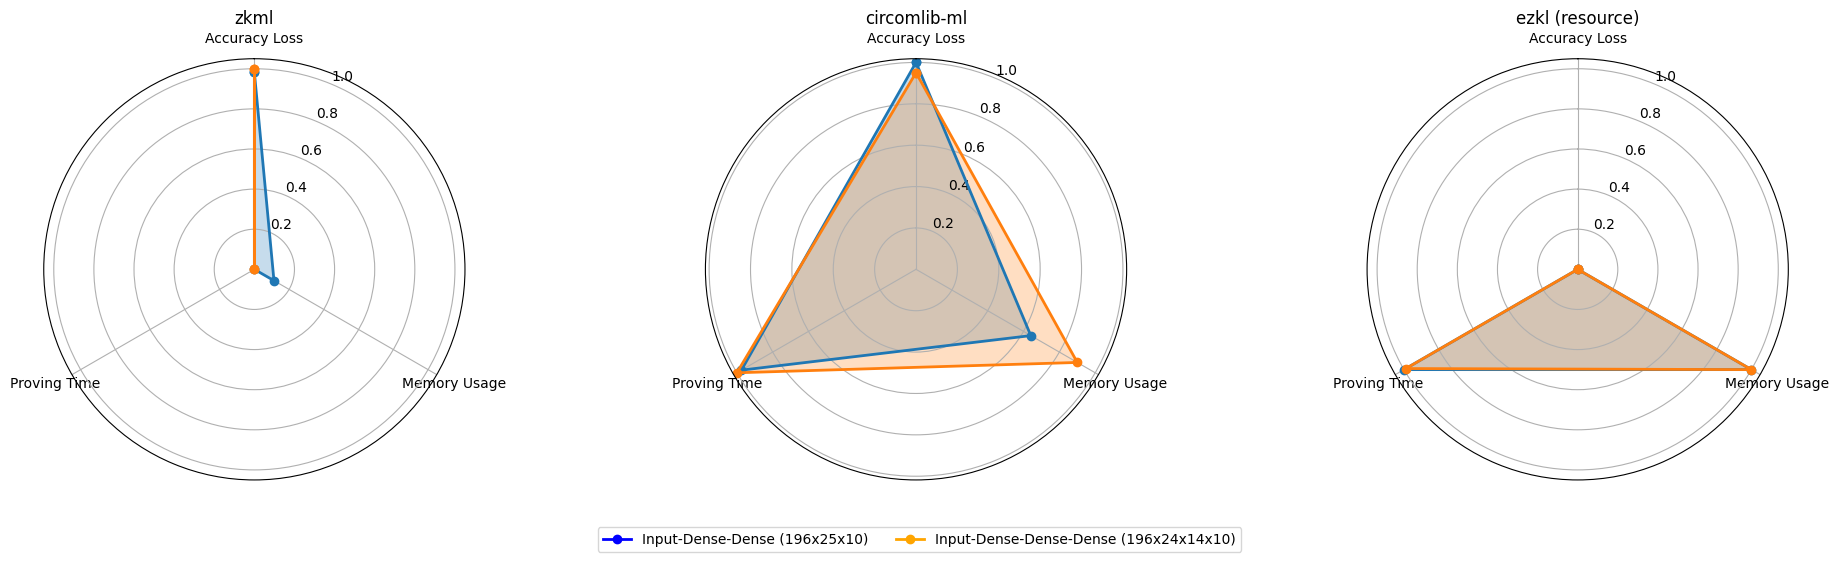

In [23]:
plot_radar_trans(architectures, transition_data, trans)

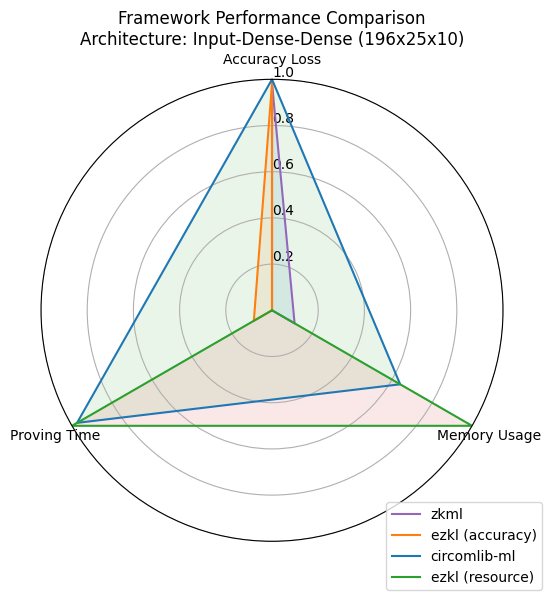

In [24]:
plot_radar_arch(transition_data, architectures[0], architectures, colors)

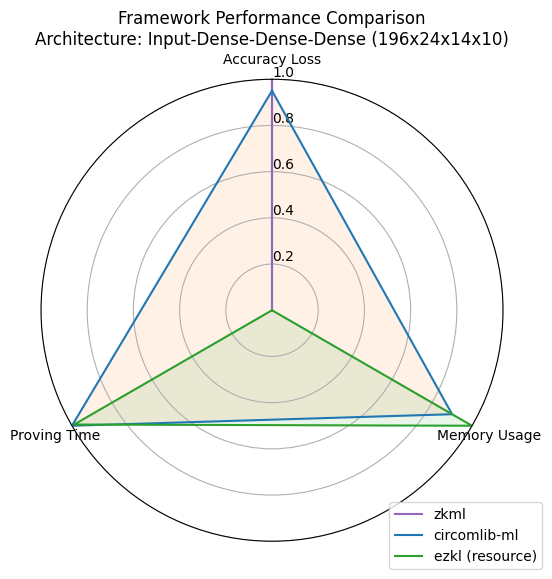

In [25]:
plot_radar_arch(transition_data, architectures[1], architectures, colors)

### Varing Param in DNN

In [26]:
trans = 'num_param-varying_dnn'

In [27]:
architectures = [target_arch(ori_models_list[1]), target_arch(ori_models_list[0])]
data = read_data_for_architectures('./benchmark_results.csv', architectures, skip = "opml")
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

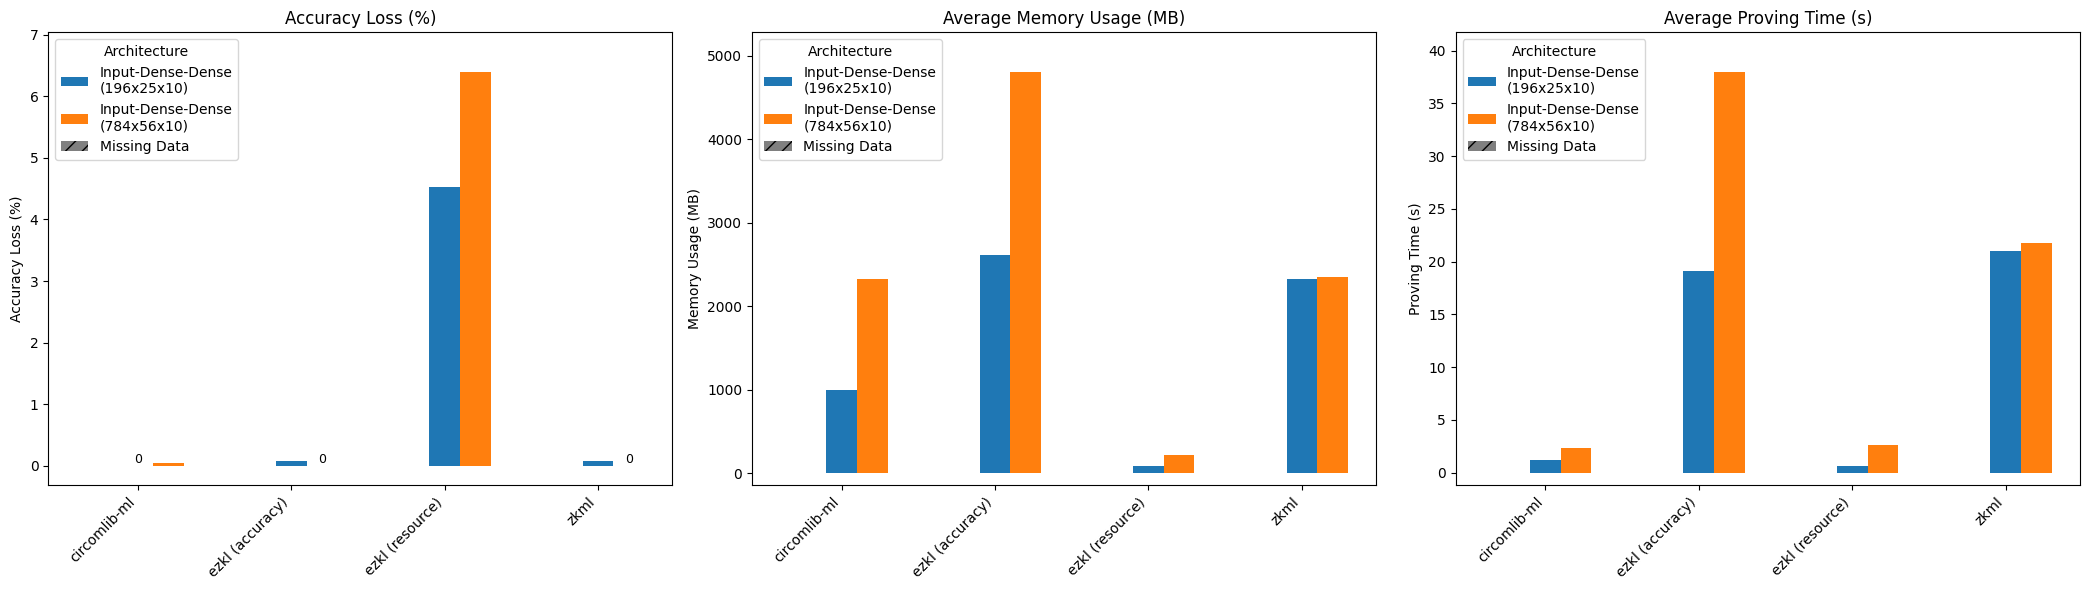

In [28]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time,trans)

In [29]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Dense-Dense (196x25x10):
  1. circomlib-ml with a score of 2.615287455004253
  2. ezkl (resource) with a score of 2.0
  3. zkml with a score of 1.0952031831552562
  4. ezkl (accuracy) with a score of 1.0732440705583803

Ranking for Input-Dense-Dense (784x56x10):
  1. circomlib-ml with a score of 2.534244700709716
  2. ezkl (resource) with a score of 1.991266669463593
  3. zkml with a score of 1.9912089211250776
  4. ezkl (accuracy) with a score of 1.0



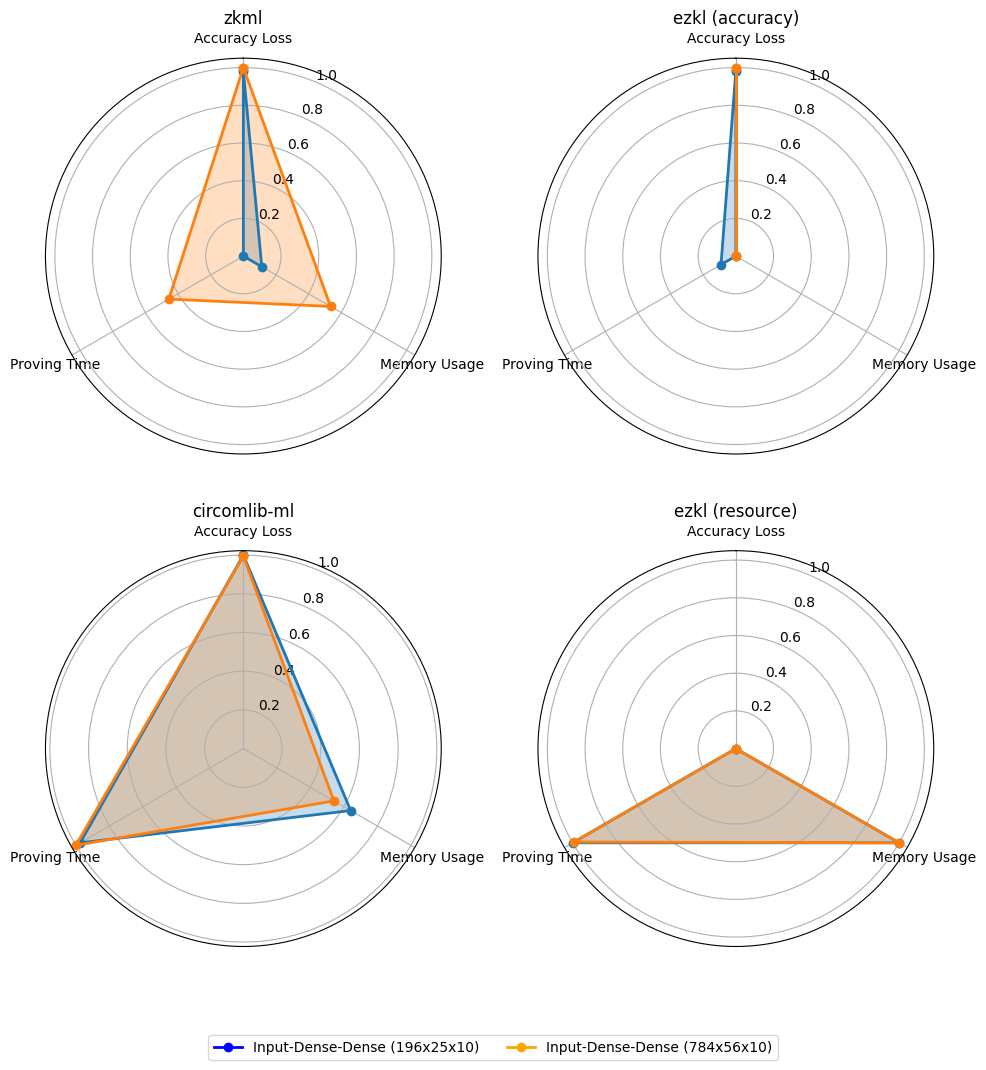

In [30]:
plot_radar_trans(architectures, transition_data,trans)

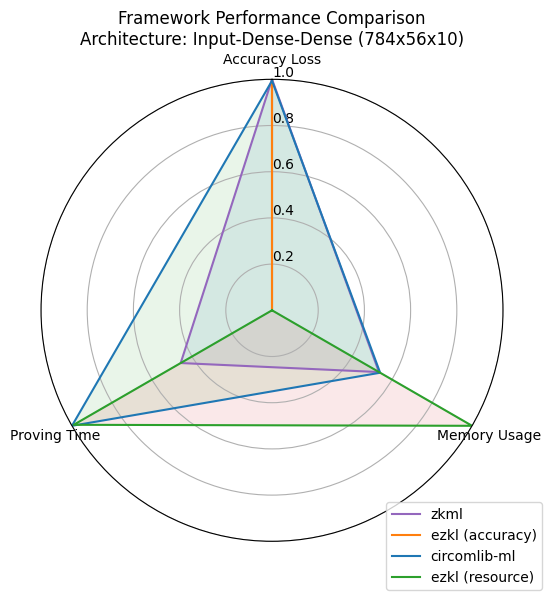

In [31]:
plot_radar_arch(transition_data, architectures[1], architectures, colors)

## CNN

### Varying Arch of CNN 

In [32]:
trans = 'arch-varying_cnn'

In [33]:
architectures = [target_arch(ori_models_list[4]), target_arch(ori_models_list[3])]
data = read_data_for_architectures('./benchmark_results.csv', architectures,skip= "opml")
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

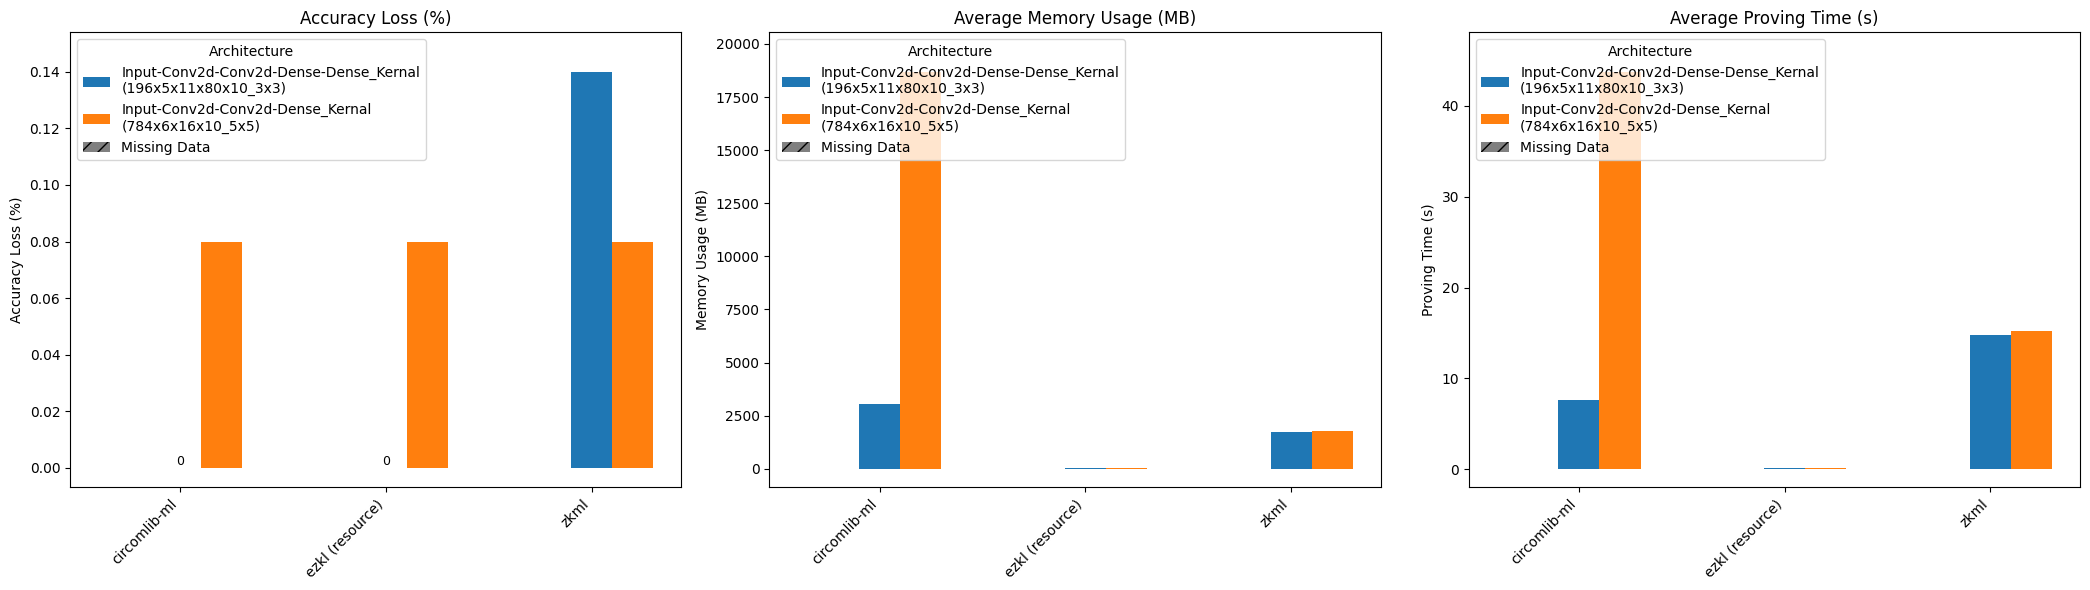

In [34]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time, trans)

In [35]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense-Dense_Kernal (196x5x11x80x10_3x3):
  1. ezkl (resource) with a score of 3.0
  2. circomlib-ml with a score of 1.4875524332179875
  3. zkml with a score of 0.43097688786553373

Ranking for Input-Conv2d-Conv2d-Dense_Kernal (784x6x16x10_5x5):
  1. ezkl (resource) with a score of 3.0
  2. zkml with a score of 2.562888049134581
  3. circomlib-ml with a score of 1.0



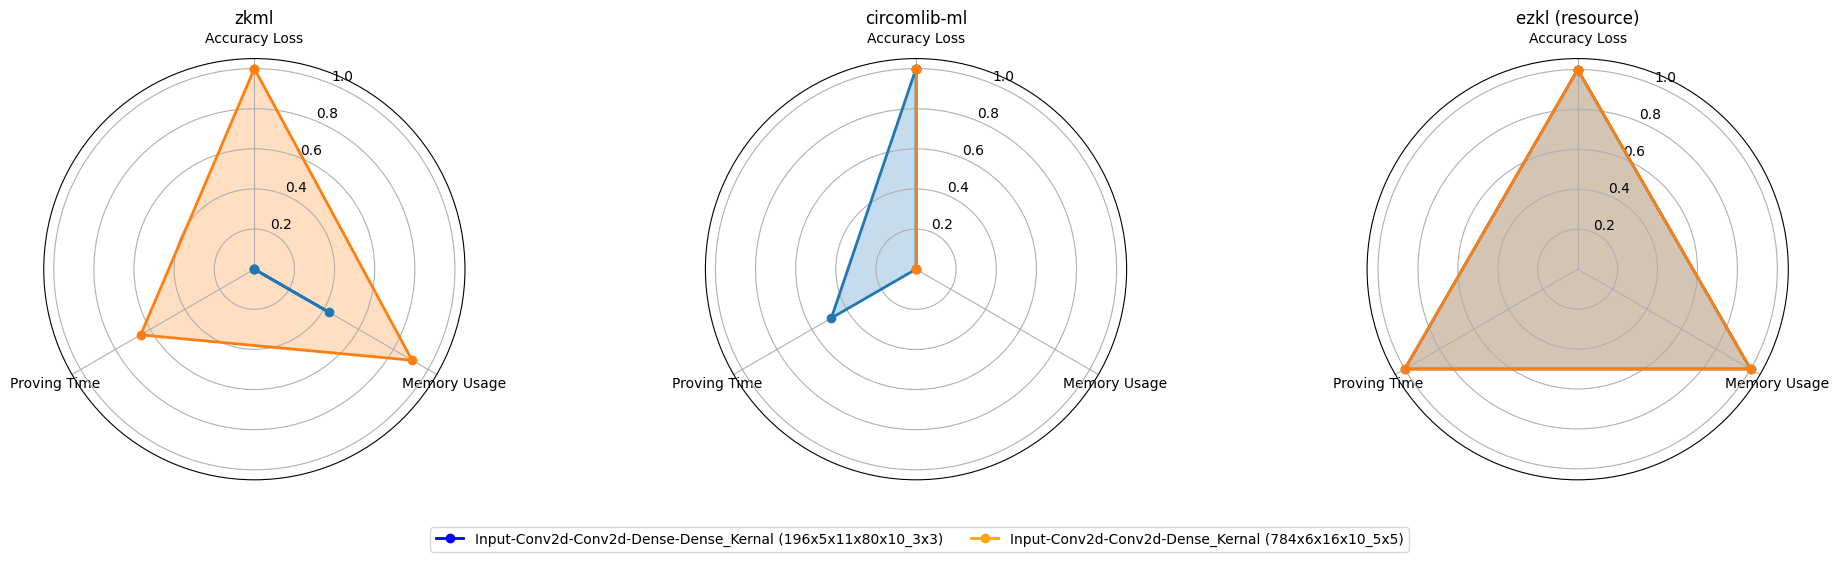

In [36]:
plot_radar_trans(architectures, transition_data,trans)

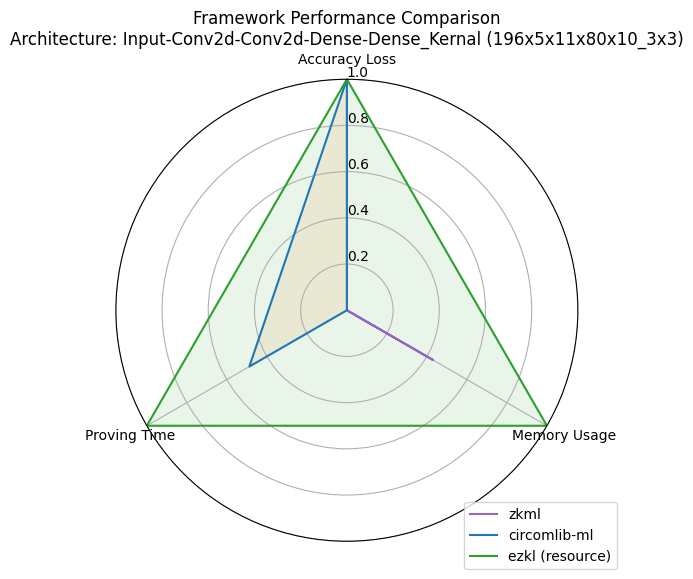

In [37]:
plot_radar_arch(transition_data, architectures[0], architectures,colors)

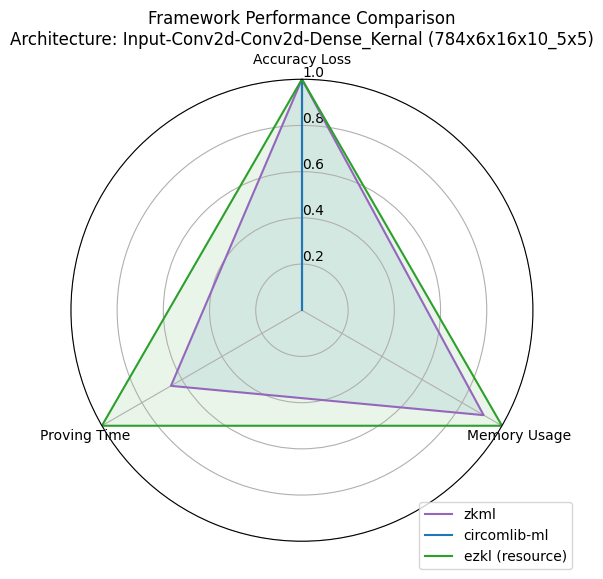

In [38]:
plot_radar_arch(transition_data, architectures[1], architectures,colors)

### Adding Extra Dense Layers

In [39]:
trans = 'add-dense_cnn'

In [40]:
architectures = [target_arch(ori_models_list[3]), target_arch(ori_models_list[5])]
data = read_data_for_architectures('./benchmark_results.csv', architectures,skip="opml")
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

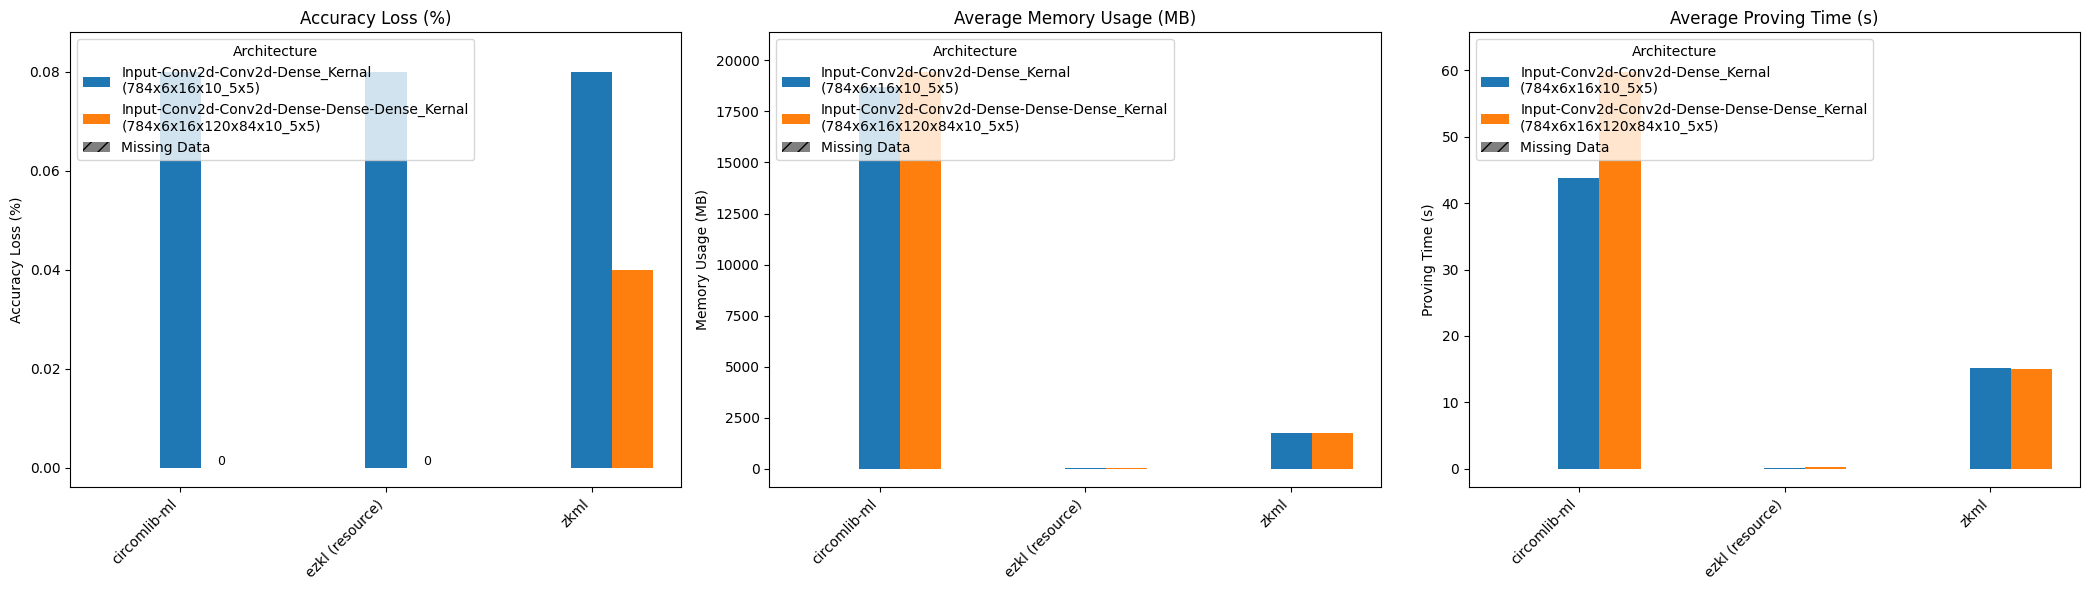

In [41]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time,trans)

In [42]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense_Kernal (784x6x16x10_5x5):
  1. ezkl (resource) with a score of 3.0
  2. zkml with a score of 2.562888049134581
  3. circomlib-ml with a score of 1.0

Ranking for Input-Conv2d-Conv2d-Dense-Dense-Dense_Kernal (784x6x16x120x84x10_5x5):
  1. ezkl (resource) with a score of 3.0
  2. zkml with a score of 1.6621057634948584
  3. circomlib-ml with a score of 1.0



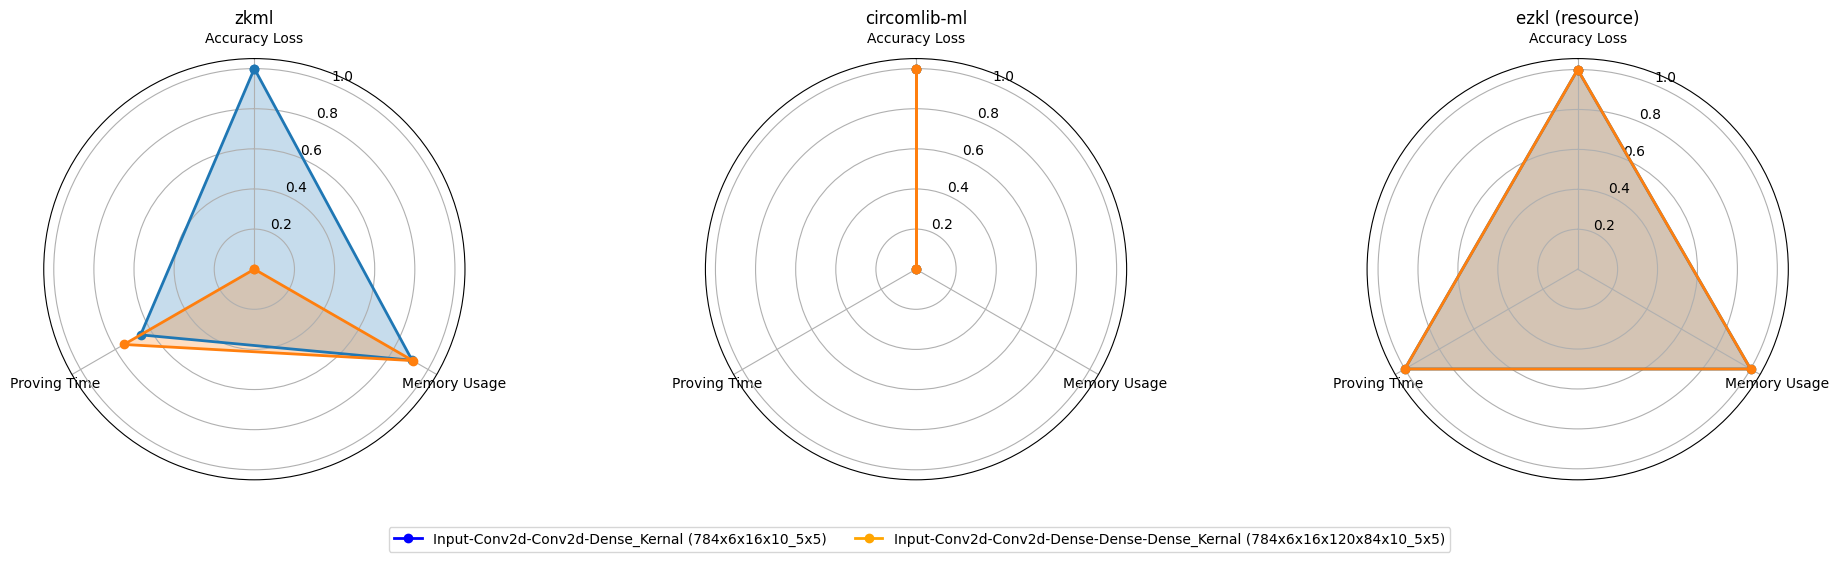

In [43]:
plot_radar_trans(architectures, transition_data,trans)

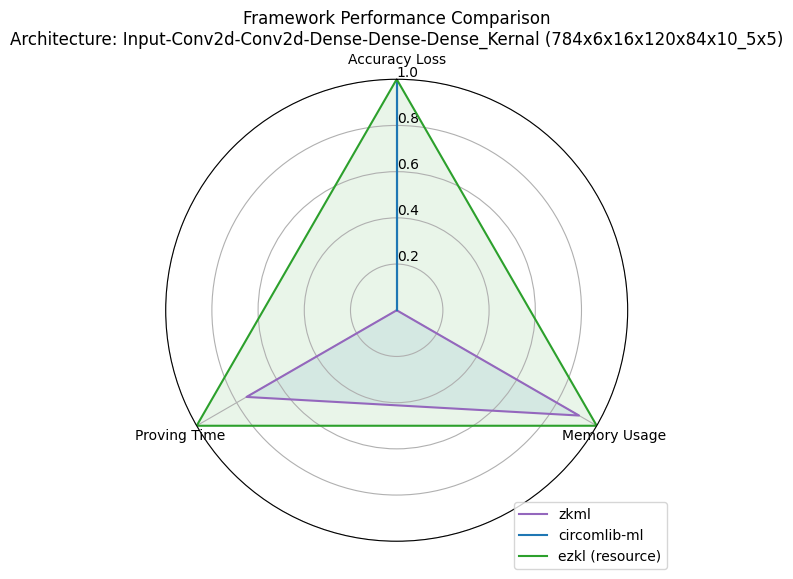

In [44]:
plot_radar_arch(transition_data, architectures[1], architectures, colors)

### Varying Layer of DNN-CNN with same # of Param

In [45]:
trans = 'same-param_cnn-dnn'

In [46]:
architectures = [target_arch(ori_models_list[5]), target_arch(ori_models_list[0])]
data = read_data_for_architectures('./benchmark_results.csv', architectures,skip="opml")
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

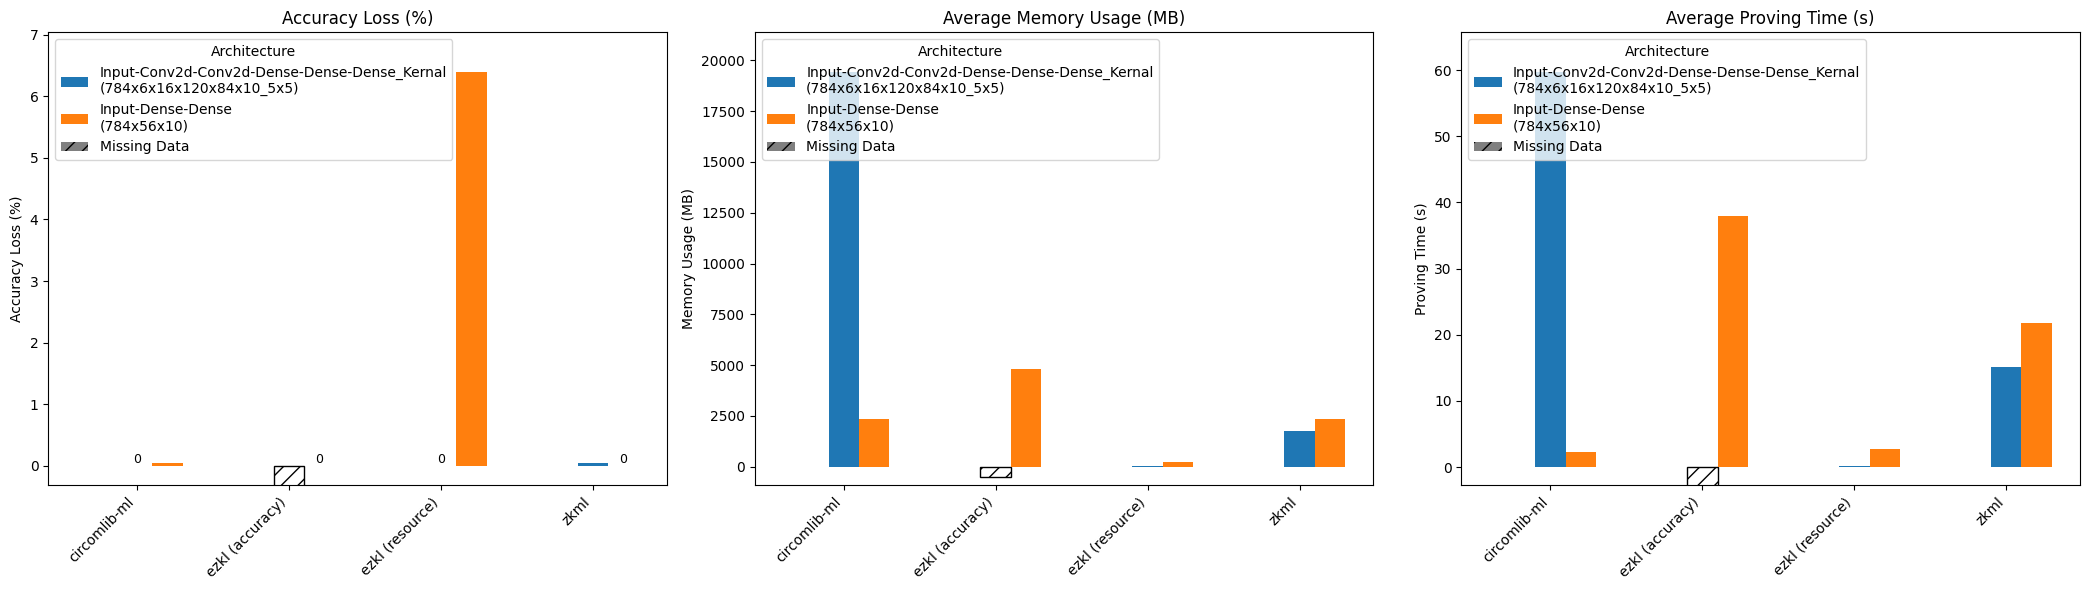

In [47]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time,trans)

In [48]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense-Dense-Dense_Kernal (784x6x16x120x84x10_5x5):
  1. ezkl (resource) with a score of 3.0
  2. zkml with a score of 1.6621057634948584
  3. circomlib-ml with a score of 1.0

Ranking for Input-Dense-Dense (784x56x10):
  1. circomlib-ml with a score of 2.534244700709716
  2. ezkl (resource) with a score of 1.991266669463593
  3. zkml with a score of 1.9912089211250776
  4. ezkl (accuracy) with a score of 1.0



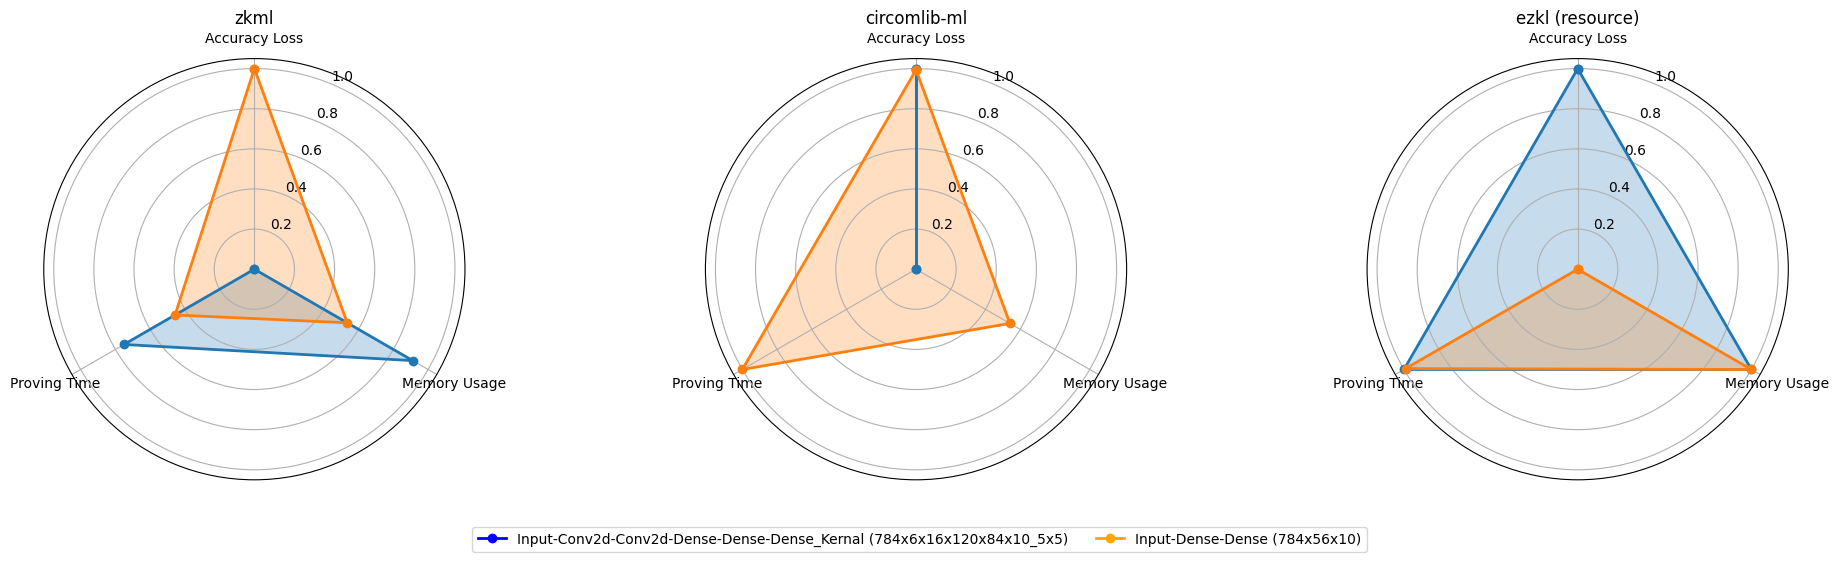

In [49]:
plot_radar_trans(architectures, transition_data,trans)

### Varying Layer of DNN-CNN with same # of layer and param

In [50]:
trans = 'same-layer-param_cnn-dnn'

In [52]:
architectures = [target_arch(ori_models_list[3]), target_arch(ori_models_list[2])]
data = read_data_for_architectures('./benchmark_results.csv', architectures,skip="opml")
frameworks, accuracy_loss, memory_usage, proving_time = extract(data, architectures)

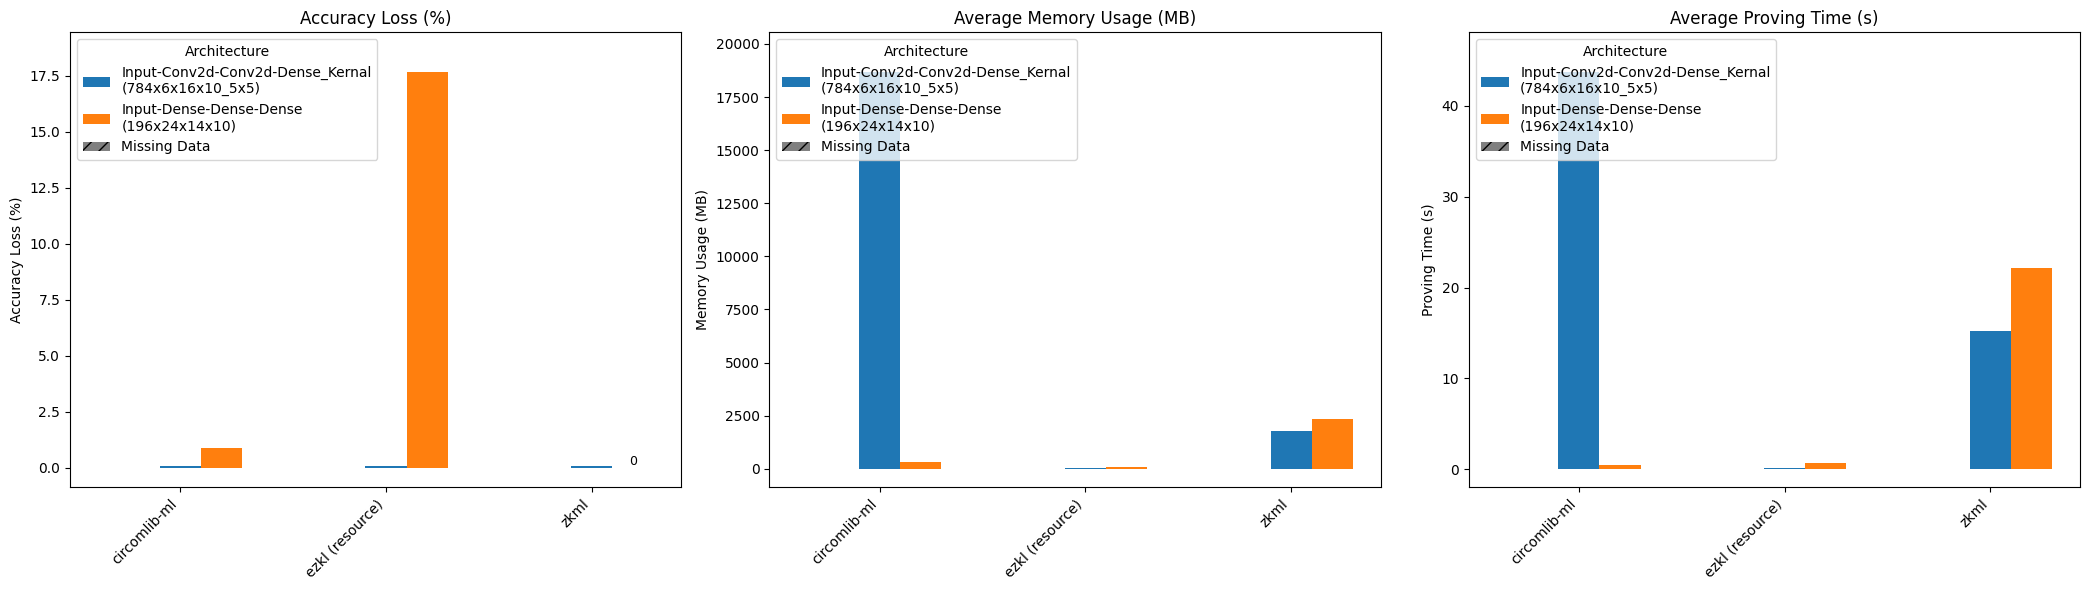

In [53]:
plot_bar(architectures, frameworks, accuracy_loss, memory_usage, proving_time,trans)

In [54]:
transition_data = prepare_radar_data(architectures, frameworks, accuracy_loss, memory_usage, proving_time)

Ranking for Input-Conv2d-Conv2d-Dense_Kernal (784x6x16x10_5x5):
  1. ezkl (resource) with a score of 3.0
  2. zkml with a score of 2.562888049134581
  3. circomlib-ml with a score of 1.0

Ranking for Input-Dense-Dense-Dense (196x24x14x10):
  1. circomlib-ml with a score of 2.8503668997135163
  2. ezkl (resource) with a score of 1.9892746198635494
  3. zkml with a score of 1.0



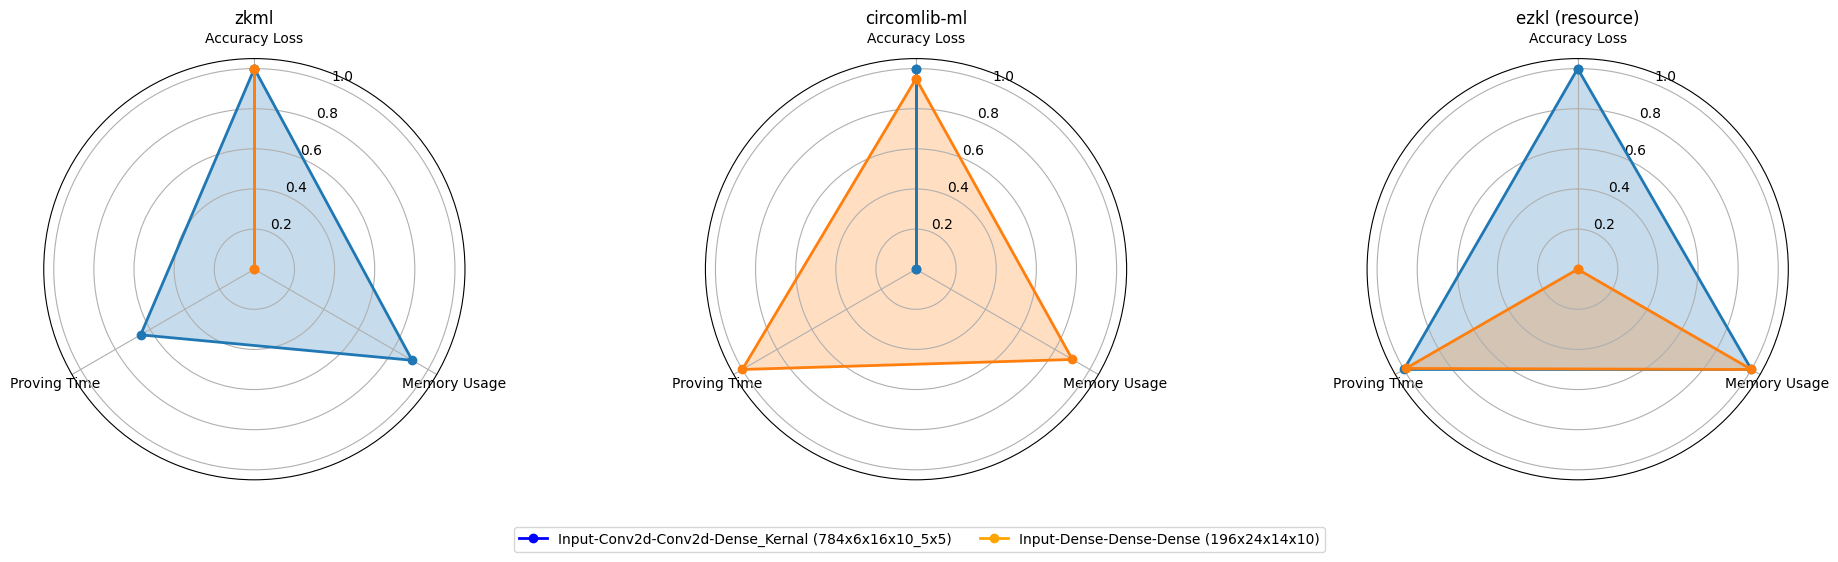

In [55]:
plot_radar_trans(architectures, transition_data,trans)

## Plots

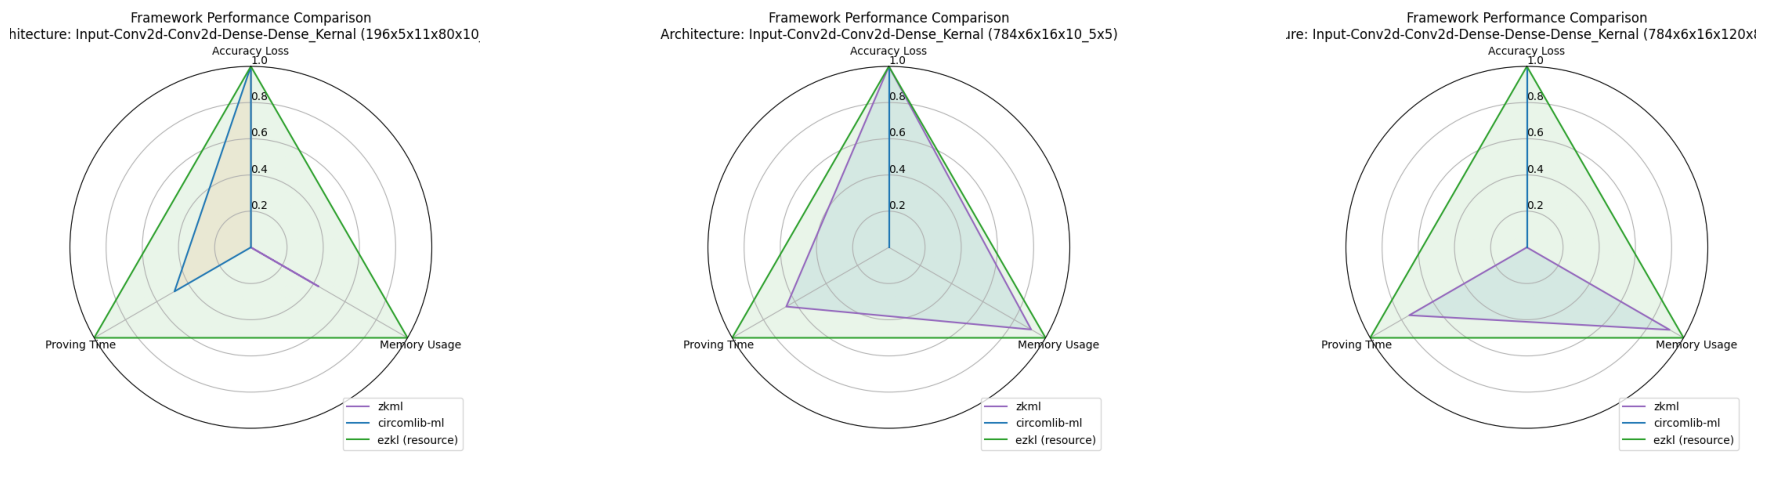

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image paths
image_paths = [
    './radar_chart/archs/196x5x11x80x10_3x3.png',
    './radar_chart/archs/784x6x16x10_5x5.png',
    './radar_chart/archs/784x6x16x120x84x10_5x5.png'
]

# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Iterate over each subplot to display images and captions
for idx, ax in enumerate(axs):
    img = mpimg.imread(image_paths[idx])
    ax.imshow(img)
    ax.axis('off')  # Hide axis
    #ax.set_title(captions[idx], fontsize=10)

plt.tight_layout()
plt.savefig("./radar_chart/3_cnn_models")
plt.show()


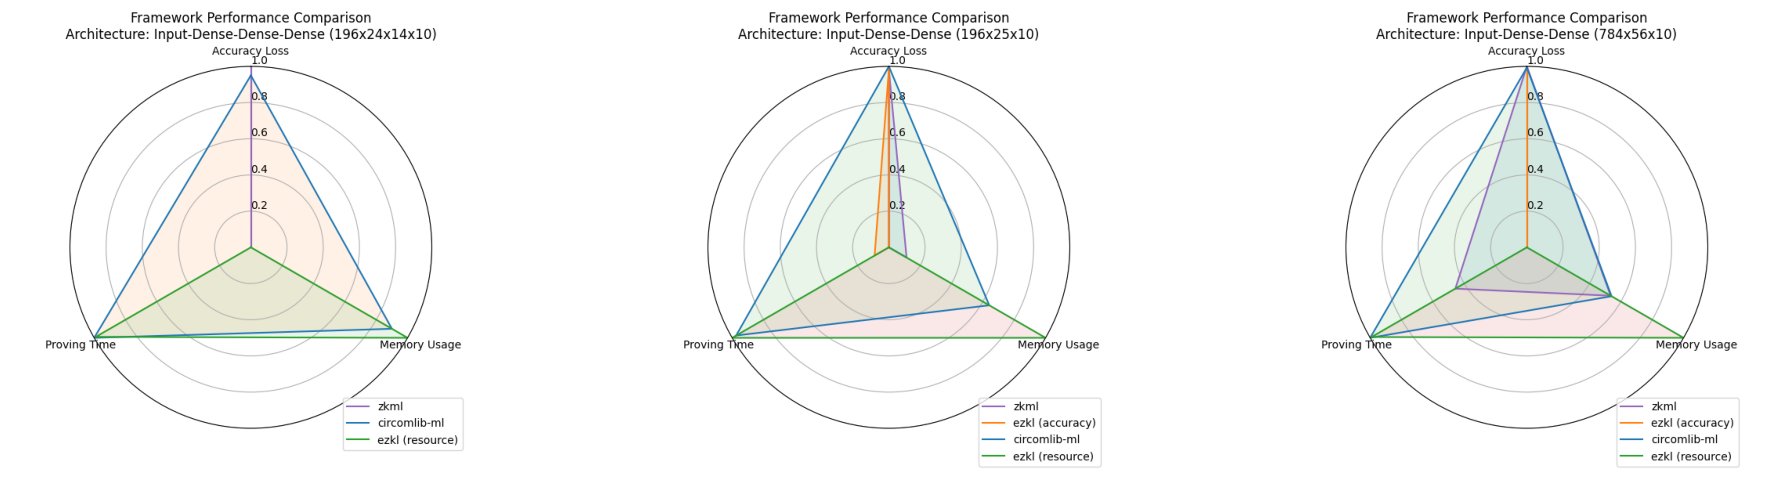

In [57]:
# Image paths
image_paths = [
    './radar_chart/archs/196x24x14x10.png',
    './radar_chart/archs/196x25x10.png',
    './radar_chart/archs/784x56x10.png'
]

# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Iterate over each subplot to display images and captions
for idx, ax in enumerate(axs):
    img = mpimg.imread(image_paths[idx])
    ax.imshow(img)
    ax.axis('off')  # Hide axis
    #ax.set_title(captions[idx], fontsize=10)

plt.tight_layout()
plt.savefig("./radar_chart/3_dnn_models")
plt.show()
